In [82]:
%reload_ext autoreload
%autoreload 2
import os
import shapley_value
import pandas as pd
import numpy as np
from getting_data import read_conf

ds_list = [
    'cslg', 'cscv', 'csai', 'csit', 'cscl',
    'cscr', 'csds', 'cssy', 'csni', 'csro',
    'csdc', 'cssi', 'cslo', 'csna', 'cscy',
    'csdm', 'csir', 'csne', 'csse', 'cscc',
    'cshc', 'csgt', 'cssd', 'csdb', 'cscg',
    'cspl', 'csma', 'csce', 'csfl', 'csdl',
    'csmm', 'csgr', 'cspf', 'csar', 'cset', 
    'csoh', 'cssc', 'csms',
]

In [83]:
xai_metrics_arr = []

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    sv = shapley_value.compute_shapley_value(exp_name, sample_name)
    
    data_len = sv.shape[0]

    sv_fi = [
        np.mean(np.abs(sv[col]))
        for col in sv.columns
    ]
    
    ale_fi = []
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        ale_npz_file = os.path.join(exp_path, 'scores', f'{sample_name}_1w_ale_{feature_name}.npz')
        ale_fi.append(np.mean(np.abs(np.load(ale_npz_file)['ale_result'])))
    

    anchor_fi = []
    _, sample_configs, __  = read_conf(exp_path)
    metrics = dict(
        title=[],
        abstract=[],
        venue=[],
        authors=[],
        year=[],
        n_citations=[],
    )
    for sample_key in sample_configs.keys():
        sample_tasks = sample_configs[sample_key]['anchor']['task']
        for task in sample_tasks:
            rg = task['range']
            m_file = os.path.join(exp_path, 'scores', f"{sample_key}_anchor_metrics_{rg[0]}_{rg[1]}.npz")
            if os.path.exists(m_file):
                ld = np.load(m_file)
                title = ld['title']
                abstract = ld['abstract']
                venue = ld['venue']
                authors = ld['authors']
                year = ld['year']
                n_citations = ld['n_citations']
                idx = ld['idx']
                
                metrics['title'].extend(title)
                metrics['abstract'].extend(abstract)
                metrics['venue'].extend(venue)
                metrics['authors'].extend(authors)
                metrics['year'].extend(year)
                metrics['n_citations'].extend(n_citations)
                
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        if len(metrics[feature_name]) < data_len:
            zeros = np.zeros([data_len - len(metrics[feature_name])])
            metrics[feature_name].extend(list(zeros))
        anchor_fi.append(np.mean(np.abs(metrics[feature_name])))
    
    shap_fi = []
    shap_sv = []
    for sample_key in sample_configs.keys():
        sample_tasks = sample_configs[sample_key]['smpshap']['task']
        for task in sample_tasks:
            rg = task['range']
            m_file = os.path.join(exp_path, 'scores', f"{sample_key}_shap_sampling_{rg[0]}_{rg[1]}.npz")
            if os.path.exists(m_file):
                ld = np.load(m_file)
                
                shap_values = ld['shap_values']
                base_values = ld['base_values']
                
                shap_sv.extend(shap_values)
                
    shap_sv = np.flipud(np.rot90(np.array(shap_sv)))
    for feature_sv in shap_sv:
        shap_fi.append(np.mean(np.abs(feature_sv)))
                
    xai_metrics_arr.append([
        sample_name,
        ale_fi, 
        sv_fi,
        anchor_fi,
        shap_fi
    ])
    
fis = ['ale_fi', 'sv_fi', 'anchor_fi', 'shap_fi']

xai_metrics_pd = pd.DataFrame(columns=['dataset', *fis], data=xai_metrics_arr)

# xai_metrics_pd

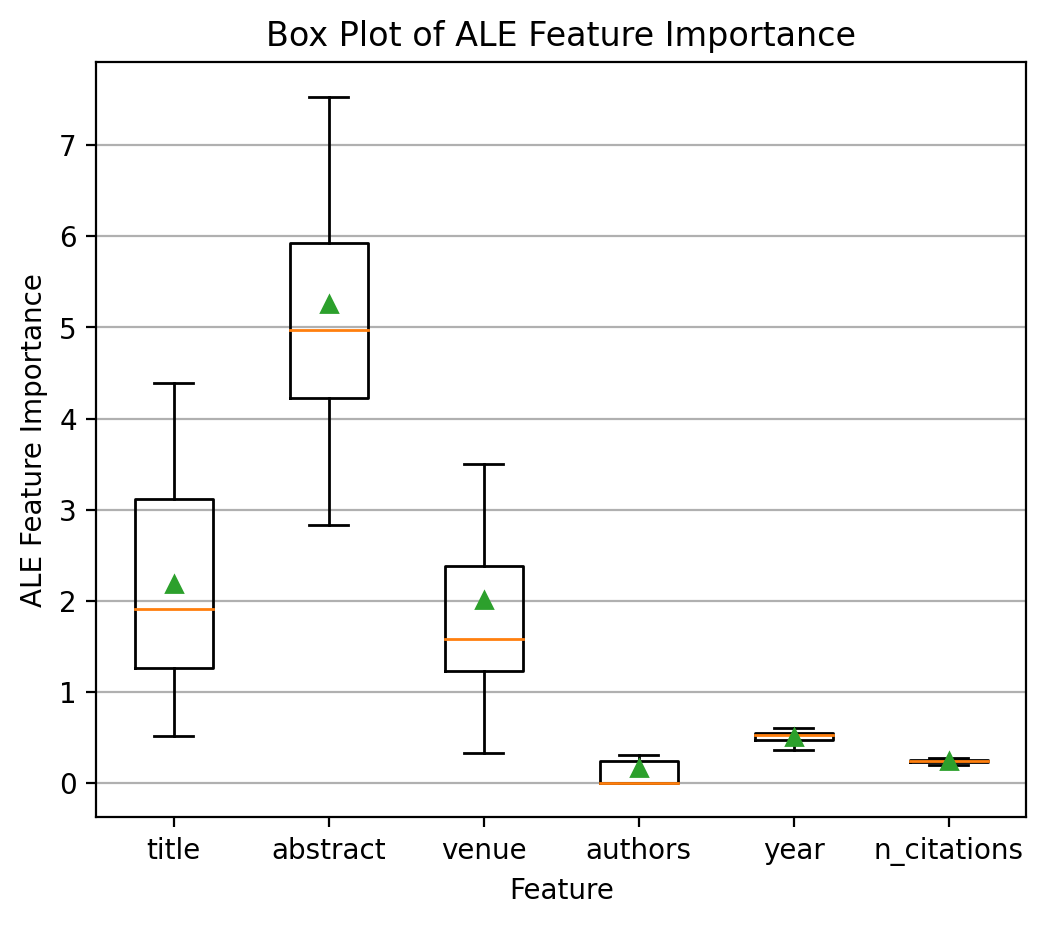

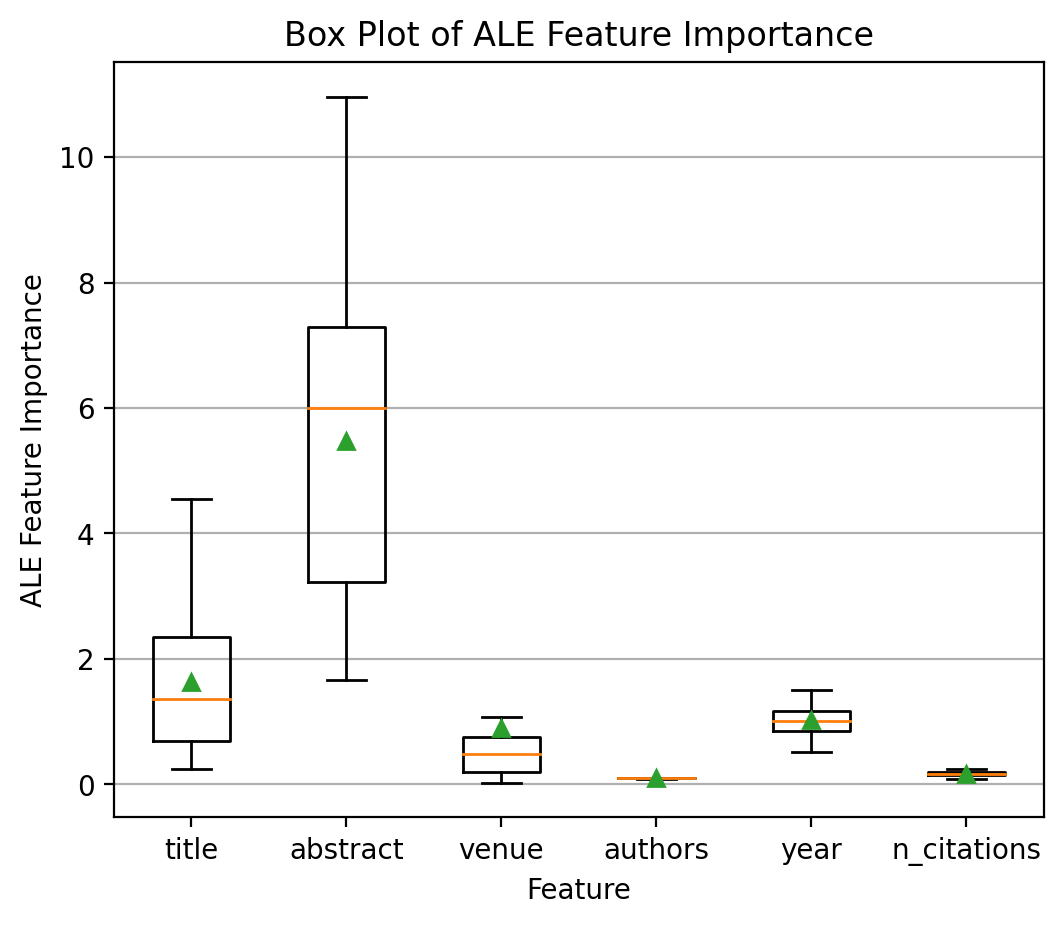

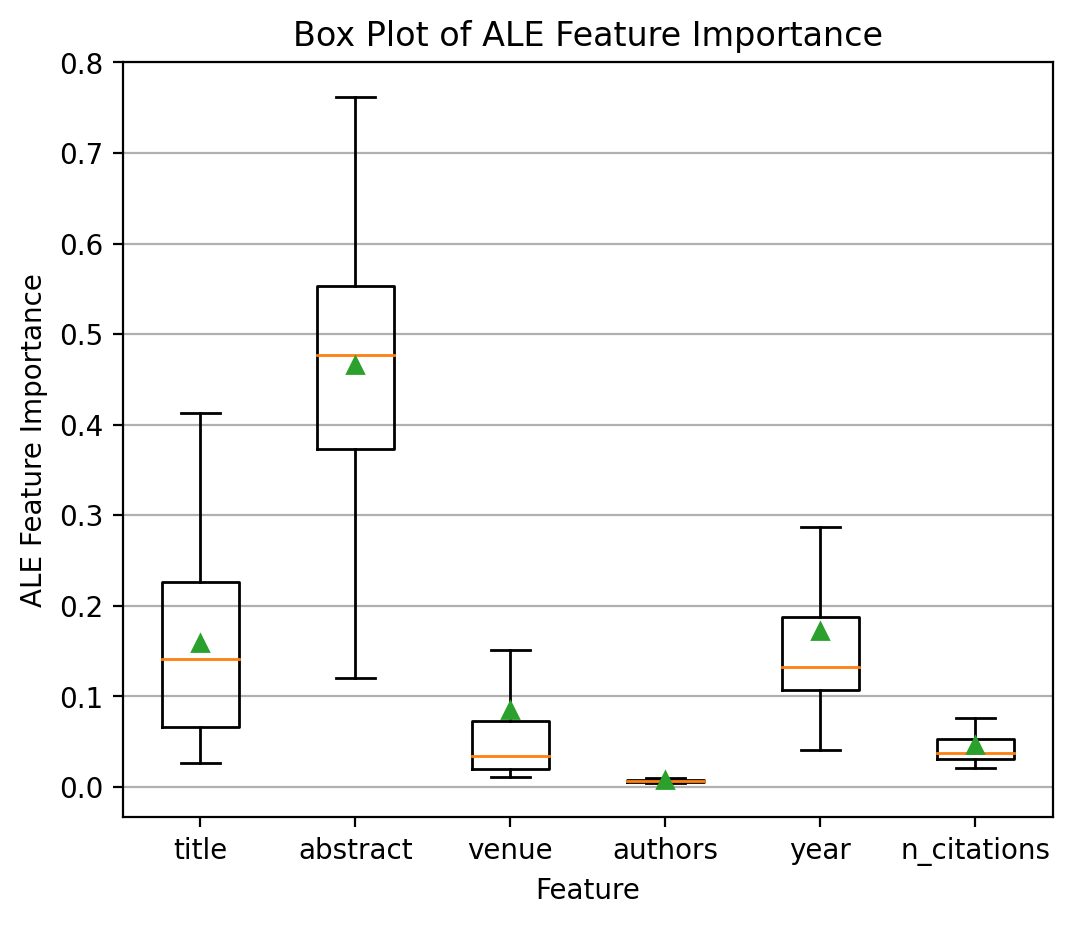

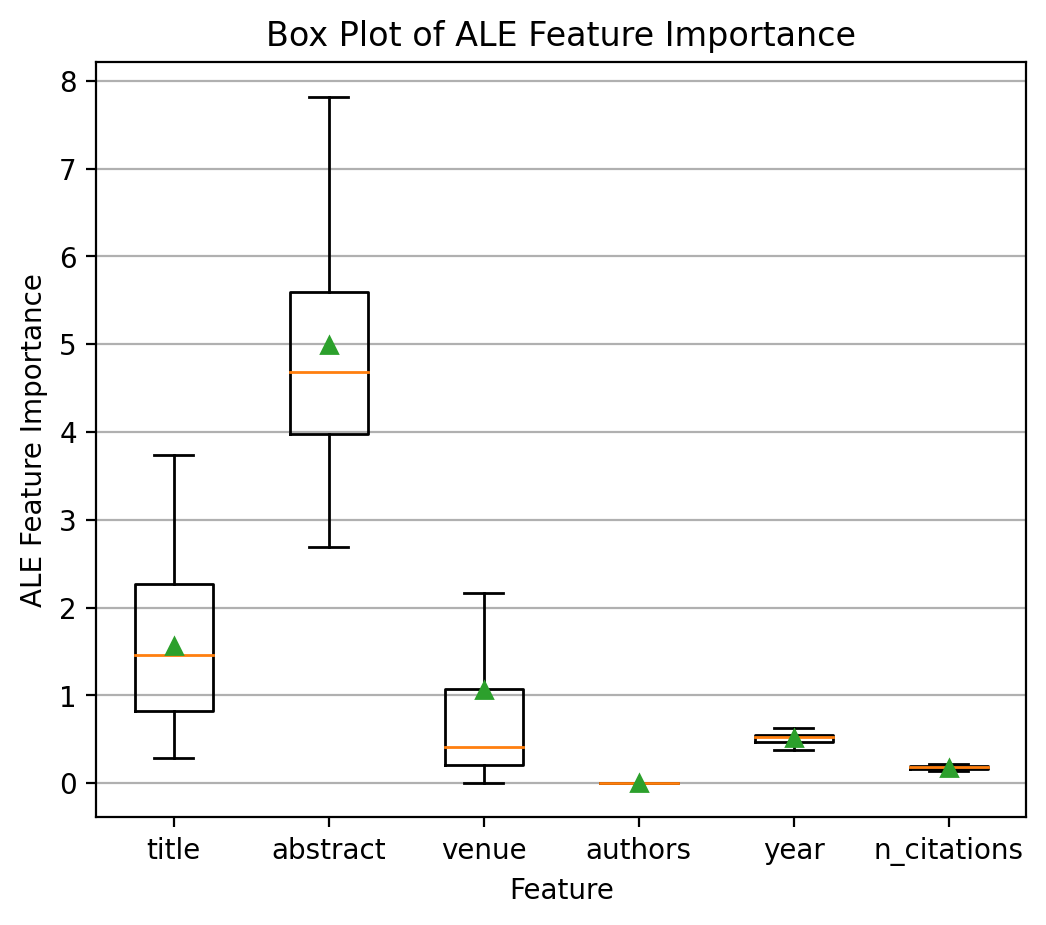

In [87]:
import matplotlib.pyplot as plt

for fi in fis:
    fi_data = (xai_metrics_pd[fi].to_list())
    fi_data = np.flipud(np.rot90((fi_data)))
    all_data = [list(l) for l in fi_data]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

    # plot box plot
    ax.boxplot(all_data, 
                showfliers=False, 
                showmeans=True,
                )
    ax.set_title('Box Plot of ALE Feature Importance')

    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                    labels=['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'])
    ax.set_xlabel('Feature')
    ax.set_ylabel('ALE Feature Importance')
